In [1]:
import os
import shutil
import sys
import yaml
import numpy as np
import pandas as pd
import random
from datetime import datetime

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import roc_auc_score, mean_squared_error, mean_absolute_error, root_mean_squared_error


from dataset.dataset_test import MolTestDatasetWrapper

from dataset.get_config import get_config 
import argparse
from torch_geometric.utils import  scatter, softmax

from torch_geometric.data import Data

import torch
from torch import nn
import torch.nn.functional as F

from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops
from torch_geometric.nn import global_add_pool, global_mean_pool, global_max_pool

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
apex_support = False
try:
    sys.path.append('./apex')
    from apex import amp

    apex_support = True
except:
    print("Please install apex for mixed precision training from: https://github.com/NVIDIA/apex")
    apex_support = False


def _save_config_file(model_checkpoints_folder):
    if not os.path.exists(model_checkpoints_folder):
        os.makedirs(model_checkpoints_folder)
        shutil.copy('./config_finetune.yaml', os.path.join(model_checkpoints_folder, 'config_finetune.yaml'))

def get_roc_auc_score(y_true, y_pred, is_valid):
    roc_list = []
    for i in range(y_true.shape[1]):
        #AUC is only defined when there is at least one positive data.
        if np.sum(y_true[:,i] == 1) > 0 and np.sum(y_true[:,i] == -1) > 0:
            is_valid = y_true[:,i]**2 > 0
            roc_list.append(roc_auc_score((y_true[is_valid,i] + 1)/2, y_pred[is_valid,i]))

    if len(roc_list) < y_true.shape[1]:
        print("Some target is missing!")
        print("Missing ratio: %f" %(1 - float(len(roc_list))/y_true.shape[1]))

    return  sum(roc_list)/len(roc_list)




class Normalizer(object):
    """Normalize a Tensor and restore it later. """

    def __init__(self, tensor):
        """tensor is taken as a sample to calculate the mean and std"""
        self.mean = torch.mean(tensor)
        self.std = torch.std(tensor)

    def norm(self, tensor):
        return (tensor - self.mean) / self.std

    def denorm(self, normed_tensor):
        return normed_tensor * self.std + self.mean

    def state_dict(self):
        return {'mean': self.mean,
                'std': self.std}

    def load_state_dict(self, state_dict):
        self.mean = state_dict['mean']
        self.std = state_dict['std']


Please install apex for mixed precision training from: https://github.com/NVIDIA/apex


In [3]:
class Args:
    batch_size = 32
    epochs = 200
    init_lr = 0.0005
    init_base_lr = 0.0001
    weight_decay = 1e-6
    
    gpu = 'cuda:1'
    model_type = 'gin'
    num_layer = 5
    emb_dim = 300
    feat_dim = 300
    dropout = 0.3
    pool = 'mean'
    seed = '42'

    task_name = 'freesolv'
    splitting = 'scaffold'
    random_masking = 1
    mask_rate = 0.2
    mask_edge = 0 
    alpha = 0.1
    reduceTrain = 1

args = Args()

In [4]:
config = yaml.load(open("config_finetune.yaml", "r"), Loader=yaml.FullLoader)

In [5]:
seed = args.seed

In [6]:
config['batch_size'] = args.batch_size
config['epochs'] = args.epochs
config['init_lr'] = args.init_lr
config['init_base_lr'] = args.init_base_lr
# config['weight_decay'] = args.weight_decay
config['gpu'] = args.gpu   
config['model']['num_layer'] = args.num_layer
config['model']['emb_dim'] = args.emb_dim
config['model']['feat_dim'] = args.feat_dim
config['model']['drop_ratio'] = args.dropout
config['model']['pool'] = args.pool

config['task_name'] = args.task_name
config['dataset']['seed'] = seed

config['dataset']['splitting'] = args.splitting

In [7]:
seed =  int(args.seed)

In [8]:
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

config['task_name'] = config['task_name'].lower()
# config['model']['mask_rate'] = args.mask_rate

In [9]:
# del config['model']['mask_rate']

In [10]:
config = get_config(config)

### main으로 넘어옴

In [11]:
import rdkit
from rdkit import Chem
from rdkit.Chem.rdchem import HybridizationType
from rdkit.Chem.rdchem import BondType as BT
from rdkit.Chem import AllChem
from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmiles
from rdkit import RDLogger

ATOM_LIST = list(range(1,119))
CHIRALITY_LIST = [
    Chem.rdchem.ChiralType.CHI_UNSPECIFIED,
    Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CW,
    Chem.rdchem.ChiralType.CHI_TETRAHEDRAL_CCW,
    Chem.rdchem.ChiralType.CHI_OTHER
]
BOND_LIST = [BT.SINGLE, BT.DOUBLE, BT.TRIPLE, BT.AROMATIC]
BONDDIR_LIST = [
    Chem.rdchem.BondDir.NONE,
    Chem.rdchem.BondDir.ENDUPRIGHT,
    Chem.rdchem.BondDir.ENDDOWNRIGHT
]

In [12]:
mol = Chem.MolFromSmiles(smiles)

NameError: name 'smiles' is not defined

In [92]:
config['dataset']['task']

'classification'

In [93]:
labels = 1

In [94]:

from tqdm import tqdm as core_tqdm
from typing import List, Set, Tuple, Union, Dict
from collections import defaultdict

def onek_encoding_unk(value : int, choices: List[int]) -> List[int]:
    """
        Creates a one-hot encoding.

    :param value: The value for which the encoding should be one.
    :param choices: A list of possible values.
    :return: A one-hot encoding of the value in a list of length len(choices) + 1.
    If value is not in the list of choices, then the final element in the encoding is 1.

    """
    encoding = [0] * len(choices)
    if value in choices:
        encoding[choices.index(value)] = 1
    else:
        encoding[-1] = 1
    return encoding

# rich_feature로 사용할 feature
ATOM_FEATURES = {
    'atomic_num' : list(range(1, 119)),
    'degree' : [0,1,2,3,4,5],
    'formal_charge' : [0, -1, -2, 1, 2],
    'chiral_tag' : [0,1,2,3],
    'num_Hs' : [0,1,2,3,4],
    'hybridization': [

        Chem.rdchem.HybridizationType.SP,
        Chem.rdchem.HybridizationType.SP2,
        Chem.rdchem.HybridizationType.SP3,
        Chem.rdchem.HybridizationType.SP3D,
        Chem.rdchem.HybridizationType.SP3D2
    ],
}

from descriptastorus.descriptors import rdDescriptors, rdNormalizedDescriptors


In [95]:
config['dataset']['task']

'classification'

In [13]:
smiles = 'CN(C)C(=O)c1ccc(cc1)OC'

In [14]:
mol = Chem.MolFromSmiles(smiles)


In [23]:
from tqdm import tqdm as core_tqdm
from typing import List, Set, Tuple, Union, Dict
from collections import defaultdict
from descriptastorus.descriptors import rdDescriptors, rdNormalizedDescriptors


def onek_encoding_unk(value : int, choices: List[int]) -> List[int]:
    """
        Creates a one-hot encoding.

    :param value: The value for which the encoding should be one.
    :param choices: A list of possible values.
    :return: A one-hot encoding of the value in a list of length len(choices) + 1.
    If value is not in the list of choices, then the final element in the encoding is 1.

    """
    encoding = [0] * len(choices)
    if value in choices:
        encoding[choices.index(value)] = 1
    else:
        encoding[-1] = 1
    return encoding

hydrogen_donor = Chem.MolFromSmarts("[$([N;!H0;v3,v4&+1]),$([O,S;H1;+0]),n&H1&+0]")
hydrogen_acceptor = Chem.MolFromSmarts(
    "[$([O,S;H1;v2;!$(*-*=[O,N,P,S])]),$([O,S;H0;v2]),$([O,S;-]),$([N;v3;!$(N-*=[O,N,P,S])]),"
    "n&H0&+0,$([o,s;+0;!$([o,s]:n);!$([o,s]:c:n)])]")
acidic = Chem.MolFromSmarts("[$([C,S](=[O,S,P])-[O;H1,-1])]")
basic = Chem.MolFromSmarts(
    "[#7;+,$([N;H2&+0][$([C,a]);!$([C,a](=O))]),$([N;H1&+0]([$([C,a]);!$([C,a](=O))])[$([C,a]);"
            "!$([C,a](=O))]),$([N;H0&+0]([C;!$(C(=O))])([C;!$(C(=O))])[C;!$(C(=O))])]")
        

# rich_feature로 사용할 feature
ATOM_FEATURES = {
    'atomic_num' : list(range(1, 119)),
    'degree' : [0,1,2,3,4,5],
    'formal_charge' : [-1, -2, 1, 2, 0],
    'chiral_tag' : [0,1,2,3],
    'num_Hs' : [0,1,2,3,4],
    'hybridization': [

        Chem.rdchem.HybridizationType.SP,
        Chem.rdchem.HybridizationType.SP2,
        Chem.rdchem.HybridizationType.SP3,
        Chem.rdchem.HybridizationType.SP3D,
        Chem.rdchem.HybridizationType.SP3D2
    ],
}

In [24]:
mol = Chem.AddHs(mol)

labels  = [1.25]
conversion = 1
N = mol.GetNumAtoms()
M = mol.GetNumBonds()

type_idx = []
chirality_idx = []
atomic_number = []
formal_charge = []
total_numHs = []
hybridzation = []
aromatic = []
mass = []

implicitValence_list = []
hydrogen_acceptor_match_list = []
hydrogen_donor_match_list = []
acidic_match_list = []
basic_match_list = []
ring_info_list = []

degree = []


hydrogen_donor = Chem.MolFromSmarts("[$([N;!H0;v3,v4&+1]),$([O,S;H1;+0]),n&H1&+0]")
hydrogen_acceptor = Chem.MolFromSmarts(
    "[$([O,S;H1;v2;!$(*-*=[O,N,P,S])]),$([O,S;H0;v2]),$([O,S;-]),$([N;v3;!$(N-*=[O,N,P,S])]),"
    "n&H0&+0,$([o,s;+0;!$([o,s]:n);!$([o,s]:c:n)])]")
acidic = Chem.MolFromSmarts("[$([C,S](=[O,S,P])-[O;H1,-1])]")
basic = Chem.MolFromSmarts(
    "[#7;+,$([N;H2&+0][$([C,a]);!$([C,a](=O))]),$([N;H1&+0]([$([C,a]);!$([C,a](=O))])[$([C,a]);"
"!$([C,a](=O))]),$([N;H0&+0]([C;!$(C(=O))])([C;!$(C(=O))])[C;!$(C(=O))])]")


for atom in mol.GetAtoms():
    type_idx.append(ATOM_LIST.index(atom.GetAtomicNum()))
    chirality_idx.append(CHIRALITY_LIST.index(atom.GetChiralTag()))
    degree.append( onek_encoding_unk(atom.GetTotalDegree(), ATOM_FEATURES['degree']) )
    formal_charge.append( onek_encoding_unk(atom.GetFormalCharge(), ATOM_FEATURES['formal_charge']) )
    total_numHs.append( onek_encoding_unk(int(atom.GetTotalNumHs()), ATOM_FEATURES['num_Hs']) )
    hybridzation.append( onek_encoding_unk(int(atom.GetHybridization()), ATOM_FEATURES['hybridization']) )
    aromatic.append([1 if atom.GetIsAromatic() else 0])
    mass.append([atom.GetMass() * 0.01])

    atom_idx = atom.GetIdx()

    hydrogen_donor_match = sum(mol.GetSubstructMatches(hydrogen_donor), ())
    hydrogen_acceptor_match = sum(mol.GetSubstructMatches(hydrogen_acceptor), ())
    acidic_match = sum(mol.GetSubstructMatches(acidic), ())
    basic_match = sum(mol.GetSubstructMatches(basic), ())

    implicitValence_list.append(onek_encoding_unk(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5, 6]))
    hydrogen_acceptor_match_list.append([atom_idx in hydrogen_acceptor_match])
    hydrogen_donor_match_list.append([atom_idx in hydrogen_donor_match])
    acidic_match_list.append([atom_idx in acidic_match])
    basic_match_list.append([atom_idx in basic_match])

    ring_info = mol.GetRingInfo()
    ring_info_list.append(                [ring_info.IsAtomInRingOfSize(atom_idx, 3),
            ring_info.IsAtomInRingOfSize(atom_idx, 4),
            ring_info.IsAtomInRingOfSize(atom_idx, 5),
            ring_info.IsAtomInRingOfSize(atom_idx, 6),
            ring_info.IsAtomInRingOfSize(atom_idx, 7),
            ring_info.IsAtomInRingOfSize(atom_idx, 8)])
                                   
                   
x1 = torch.tensor(type_idx, dtype=torch.long).view(-1, 1)
x2 = torch.tensor(chirality_idx, dtype=torch.long).view(-1, 1)
x3 = torch.tensor(degree, dtype=torch.long)
x4 = torch.tensor(formal_charge, dtype=torch.long)
x5 = torch.tensor(total_numHs, dtype=torch.long)
x6 = torch.tensor(hybridzation, dtype=torch.long)
x7 = torch.tensor(aromatic, dtype=torch.long)
x8 = torch.tensor(mass, dtype=torch.float)

x9 = torch.tensor(implicitValence_list, dtype=torch.long)
x10 = torch.tensor(hydrogen_acceptor_match_list, dtype=torch.long)
x11 = torch.tensor(hydrogen_donor_match_list, dtype=torch.long)
x12 = torch.tensor(acidic_match_list, dtype=torch.long)
x13 = torch.tensor(basic_match_list, dtype=torch.long)
x14 = torch.tensor(ring_info_list, dtype=torch.long)


x = torch.cat([x1, x2, x3, x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14], dim=1)

row, col, edge_feat = [], [], []
for bond in mol.GetBonds():
    start, end = bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()
    row += [start, end]
    col += [end, start]
    bt = bond.GetBondType()
    feat1 = [
        BOND_LIST.index(bond.GetBondType()),
        BONDDIR_LIST.index(bond.GetBondDir()),
        bond.GetIsConjugated() if bt is not None else 0,
        bond.IsInRing() if bt is not None else 0,
        *onek_encoding_unk(int(bond.GetStereo()), list(range(6)))
    ]
    edge_feat.append(feat1)

    # 반대 방향의 엣지(또는 같은 특성을 반복) 특성 계산
    # 여기서는 예시로 feat1을 그대로 사용합니다. 필요에 따라 다른 계산을 할 수 있습니다.
    feat2 = feat1  # 또는 반대 방향에 대한 다른 계산 결과
    edge_feat.append(feat2)
        

edge_index = torch.tensor([row, col], dtype=torch.long)
edge_attr = torch.tensor(np.array(edge_feat), dtype=torch.long)
if config['dataset']['task'] == 'classification':
    y = torch.tensor(labels, dtype=torch.long).view(1,-1)
elif config['dataset']['task'] == 'regression':
    y = torch.tensor(labels * conversion, dtype=torch.float).view(1,-1)


normalized_2d_generator = rdNormalizedDescriptors.RDKit2DNormalized()
x_add = normalized_2d_generator.process(smiles)
if x_add is None:
    # x_add가 None인 경우, 처리 방식 결정
    # 예: 빈 특성 리스트 또는 기본값 설정
    print(f"Warning: No features generated for SMILES: {smiles}")
    x_add = [] # 예시 기본값
else:
    # x_add를 텐서로 변환

    x_add = torch.tensor(np.array(x_add[1:]), dtype=torch.long).view(1, -1)

In [27]:
# sample x distinct atoms to be masked, based on mask rate. But
# will sample at least 1 atom
mask_rate = 0.2
num_atoms = x.size()[0]
sample_size = int(num_atoms * mask_rate + 1)
masked_atom_indices = random.sample(range(num_atoms), sample_size)

In [29]:
mask_node_labels_list = []
for atom_idx in masked_atom_indices:
    mask_node_labels_list.append(x[atom_idx].view(1, -1))
mask_node_label = torch.cat(mask_node_labels_list, dim=0)

In [31]:
masked_atom_indices

[12, 22, 24, 17, 19, 6]

In [32]:
connected_edge_indices = []
for bond_idx, (u, v) in enumerate(edge_index.cpu().numpy().T):
    for atom_idx in masked_atom_indices:

        
        if atom_idx in set((u, v)) and \
            bond_idx not in connected_edge_indices:


            connected_edge_indices.append(bond_idx)

In [34]:
if len(connected_edge_indices) > 0:
    # create mask edge labels by copying bond features of the bonds connected to
    # the mask atoms
    mask_edge_labels_list = []
    for bond_idx in connected_edge_indices[::2]: # because the
        # edge ordering is such that two directions of a single
        # edge occur in pairs, so to get the unique undirected
        
        # edge indices, we take every 2nd edge index from list
        mask_edge_labels_list.append(
            edge_attr[bond_idx].view(1, -1))

    mask_edge_label = torch.cat(mask_edge_labels_list, dim=0)
    # modify the original bond features of the bonds connected to the mask atoms

    connected_edge_indices = torch.tensor(
        connected_edge_indices[::2])
else:
    mask_edge_label = torch.empty((0, 10)).to(torch.int64)
    connected_edge_indices = torch.tensor(
        connected_edge_indices).to(torch.int64)


In [37]:
edge_index.shape

torch.Size([2, 52])

In [38]:
connected_edge_indices.shape

torch.Size([9])

In [ ]:
data = Data(x=x, y=y, edge_index=edge_index, edge_attr=edge_attr, x_add = x_add)

In [97]:
data = data.to(device)

In [98]:
data.batch = torch.zeros(x.size(0), dtype=torch.long).to(device)

In [99]:
h_node, pred, node = model(data,3)

In [100]:
N = mol.GetNumAtoms()

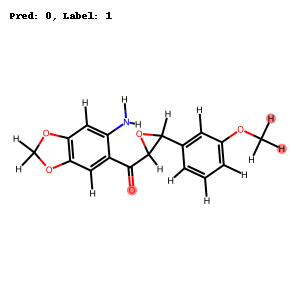

In [101]:
from rdkit.Chem import Draw

img = Draw.MolToImage(mol, highlightAtoms=node.tolist())
from PIL import Image, ImageDraw


pred_max_index = pred.detach().cpu().numpy().argmax()
# 이미지에 텍스트 추가 (예측 결과와 실제 레이블)
draw = ImageDraw.Draw(img)
text = f"Pred: {pred_max_index}, Label: {data.y.item()}"
draw.text((10, 10), text, fill="black")

# save_path = os.path.join(save_dir, f"molecule_3mr.png")
# img.save(save_path)  # 파일 이름을 분자의 인덱스에 따라 지정
display(img)

## 파이썬 파일 실행

In [160]:
datasets = ['tox21',  'sider',]

for dataset in datasets:
            if dataset == 'FreeSolv':
            # FreeSolv 데이터셋에 대한 특정 옵션을 적용
                !python finetuneReconEmbedding_random_tsne.py \
                --task_name {dataset} \
                --seed 781 \
                --dropout 0.5 \
                --num_layer 3 \
                --emb_dim 64 \
                --feat_dim 64 \
                --gpu cuda:1
         
                    
            else:
                !python finetuneReconEmbedding_random_tsne.py \
                --task_name {dataset} \
                --seed 781 \
                --gpu cuda:1 \
                --mask_rate 0.2 

                

Please install apex for mixed precision training from: https://github.com/NVIDIA/apex
{'batch_size': 32, 'epochs': 200, 'eval_every_n_epochs': 1, 'fine_tune_from': 'pretrained_gin', 'log_every_n_steps': 50, 'fp16_precision': False, 'init_lr': 0.0005, 'init_base_lr': 0.0001, 'weight_decay': '1e-6', 'gpu': 'cuda:1', 'task_name': 'tox21', 'model_type': 'gin', 'model': {'num_layer': 5, 'emb_dim': 300, 'feat_dim': 300, 'drop_ratio': 0.3, 'pool': 'mean'}, 'dataset': {'num_workers': 4, 'valid_size': 0.1, 'test_size': 0.1, 'splitting': 'scaffold', 'seed': 781, 'task': 'classification', 'data_path': 'data/tox21/tox21.csv', 'target': ['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD', 'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53']}}
Running on: cuda:1
3079
About to generate scaffolds
Generating scaffold 0/3079
Generating scaffold 1000/3079
Generating scaffold 2000/3079
Generating scaffold 3000/3079
About to sort in scaffold sets
pred_head.0.weight True
pr

In [159]:
!python finetuneReconEmbedding_random_tsne.py \
--task_name sider \
--seed 781 \
--gpu cuda:0 \
--alpha 0.1 \
--weight_decay 1e-6 \
--mask_rate 0.2 \
--epochs 1

Please install apex for mixed precision training from: https://github.com/NVIDIA/apex
{'batch_size': 32, 'epochs': 1, 'eval_every_n_epochs': 1, 'fine_tune_from': 'pretrained_gin', 'log_every_n_steps': 50, 'fp16_precision': False, 'init_lr': 0.0005, 'init_base_lr': 0.0001, 'weight_decay': '1e-6', 'gpu': 'cuda:0', 'task_name': 'sider', 'model_type': 'gin', 'model': {'num_layer': 5, 'emb_dim': 300, 'feat_dim': 300, 'drop_ratio': 0.3, 'pool': 'mean'}, 'dataset': {'num_workers': 4, 'valid_size': 0.1, 'test_size': 0.1, 'splitting': 'scaffold', 'seed': 781, 'task': 'classification', 'data_path': 'data/sider/sider.csv', 'target': ['Hepatobiliary disorders', 'Metabolism and nutrition disorders', 'Product issues', 'Eye disorders', 'Investigations', 'Musculoskeletal and connective tissue disorders', 'Gastrointestinal disorders', 'Social circumstances', 'Immune system disorders', 'Reproductive system and breast disorders', 'Neoplasms benign, malignant and unspecified (incl cysts and polyps)', 'Gen

In [158]:
!python finetune3_tsne.py \
 --task_name bace \
--seed 750 \
--gpu cuda:0 \
--weight_decay 1e-6 \
--mask_rate 0.2

Please install apex for mixed precision training from: https://github.com/NVIDIA/apex
{'batch_size': 32, 'epochs': 200, 'eval_every_n_epochs': 1, 'fine_tune_from': 'pretrained_gin', 'log_every_n_steps': 50, 'fp16_precision': False, 'init_lr': 0.0005, 'init_base_lr': 0.0001, 'weight_decay': '1e-6', 'gpu': 'cuda:0', 'task_name': 'bace', 'model_type': 'gin', 'model': {'num_layer': 5, 'emb_dim': 300, 'feat_dim': 300, 'drop_ratio': 0.3, 'pool': 'mean'}, 'dataset': {'num_workers': 4, 'valid_size': 0.1, 'test_size': 0.1, 'splitting': 'scaffold', 'seed': 750, 'task': 'classification', 'data_path': 'data/bace/bace.csv', 'target': ['Class']}}
Running on: cuda:0
1512
About to generate scaffolds
Generating scaffold 0/1512
Generating scaffold 1000/1512
About to sort in scaffold sets
pred_head.0.weight True
pred_head.0.bias True
pred_head.2.weight True
pred_head.2.bias True
pred_head.4.weight True
pred_head.4.bias True
0 0 0.6962036490440369
Validation loss: 0.831542025338735 ROC AUC: 0.473777462792